In [11]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF

In [12]:
# Read in clean HG dataset with new madres data
cleaned_visits = pd.read_excel('May_2025/cleaned_visits_5.30.25.xlsx')

In [13]:
cleaned_visits.head()

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
0,normal,no,madres,1065_WA03928,NaT,1,3461.341268,8839.392887,105294.697759,13.4286,...,NaN,4.0,145.025055,NaN,NaN,Low,Unknown,NaN,NaN,NaN
1,normal,no,madres,122_RH08462,NaT,1,3137.791124,27895.856937,104011.519071,13.8571,...,NaN,3.0,100.016595,NaN,NaN,Low,Unknown,NaN,NaN,NaN
2,hg,yes,madres,154_IN05817,NaT,1,86824.003245,17909.352716,110847.711827,11.5700,...,NaN,14.0,179.030000,NaN,NaN,High,Unknown,NaN,NaN,NaN
3,normal,no,madres,165_WD02107,NaT,1,3672.951842,10730.503904,155319.325818,12.2857,...,NaN,6.0,141.022980,NaN,NaN,Low,Unknown,NaN,NaN,NaN
4,normal,no,madres,186_CE07588,NaT,1,35513.496640,15229.454545,88817.509876,10.8571,...,NaN,3.0,149.024925,NaN,NaN,Low,Unknown,NaN,NaN,NaN


# EDA

## Madres Data

In [14]:
madres = cleaned_visits[cleaned_visits['Clinic'] == "madres"]
madres.head()
madres.columns

Index(['Other Notes', 'HG', 'Clinic', 'ID', 'Date', 'Visit_Number', 'TCF7L2',
       'GDF15', 'IGFBP7', 'EGA_Weeks', 'Race', 'HELP', 'PUQE',
       'Prepregnancy_Weight', 'Current_Weight',
       'Weight_Change_from_Prepregnancy', 'PUQE_Severity', 'HELP_Severity',
       'Weight_Change_from_Last_Visit', 'Weight_Difference_from_Prepreg (%)',
       'Weight_Difference_from_Last'],
      dtype='object')

In [15]:
# split madres data with hg and without hg
madres_normal = madres[madres['HG'] == 'no']
madres_hg = madres[madres['HG'] == 'yes']

## Helper Functions

In [18]:
# Function for boxplots to analyze various attribute distribution amongst those with and without HG
def dist_boxplot(df, col):
    sns.boxplot(data=df, x='HG', y=col, hue='HG', legend=False)
    plt.title(col + " by HG Status")

# Function to test for Statistical Significance in Difference between Sample Means
def perform_statistical_tests(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return
    
    # Perform Shapiro-Wilk normality tests
    shapiro_group1 = stats.shapiro(group1_data)
    shapiro_group2 = stats.shapiro(group2_data)
    
    print(f"Shapiro-Wilk test for {group1} (n={len(group1_data)}): p-value = {shapiro_group1.pvalue}")
    print(f"Shapiro-Wilk test for {group2} (n={len(group2_data)}): p-value = {shapiro_group2.pvalue}")
    
    # Check if both groups are normally distributed
    if shapiro_group1.pvalue >= 0.05 and shapiro_group2.pvalue >= 0.05:
        print("Both groups are normally distributed. Performing t-tests.")
        
        # Perform Independent t-test (assuming equal variances)
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
        print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
        
        # Perform Welch's t-test if unequal variances are suspected
        t_stat_welch, p_value_welch = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        print(f"Welch's t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat_welch}, p-value = {p_value_welch}")
    
    else:
        print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
        
        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value_mwu = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"Mann-Whitney U test result (n={len(group1_data)} vs. n={len(group2_data)}): U-statistic = {u_stat}, p-value = {p_value_mwu}")

## Boxplot Distributions - Madres Only

### PUQE by HG Status

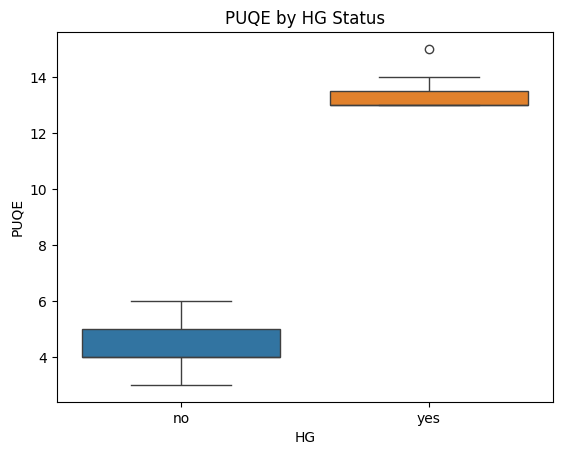

In [19]:
dist_boxplot(madres, 'PUQE')

#### Stat Sig - Yes (to be expected)

In [20]:
perform_statistical_tests(madres, "HG", "PUQE", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.0009314464717012313
Shapiro-Wilk test for no (n=32): p-value = 0.0014658277589733213
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 224.0, p-value = 3.059679328193466e-05


### EGA by HG Status

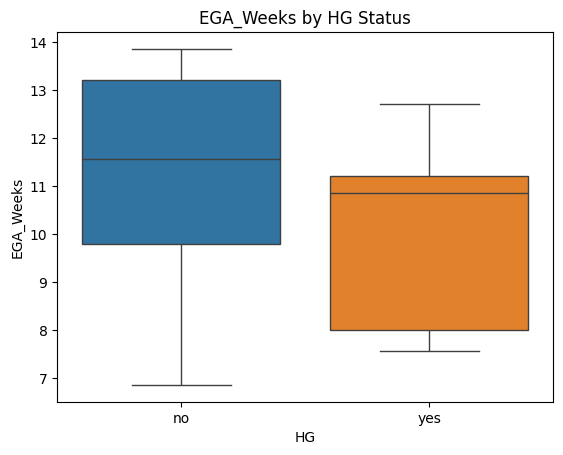

In [21]:
dist_boxplot(madres, 'EGA_Weeks')

#### Stat Sig - No

In [25]:
perform_statistical_tests(madres, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.23061323345102042
Shapiro-Wilk test for no (n=32): p-value = 0.01805836587254208
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 66.0, p-value = 0.09550027849976168


### Prepregnancy Weight by HG Status

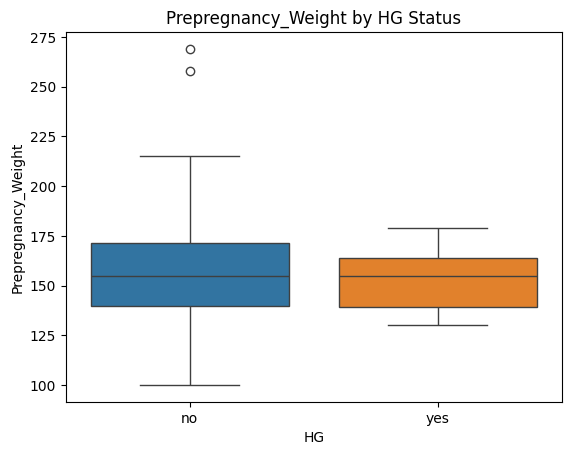

In [26]:
dist_boxplot(madres, 'Prepregnancy_Weight')

#### Stat Sig - No

In [27]:
perform_statistical_tests(madres, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.7820986963403859
Shapiro-Wilk test for no (n=32): p-value = 0.002839808874140585
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 103.0, p-value = 0.7556650004303852


### TCF7L2 by HG Status

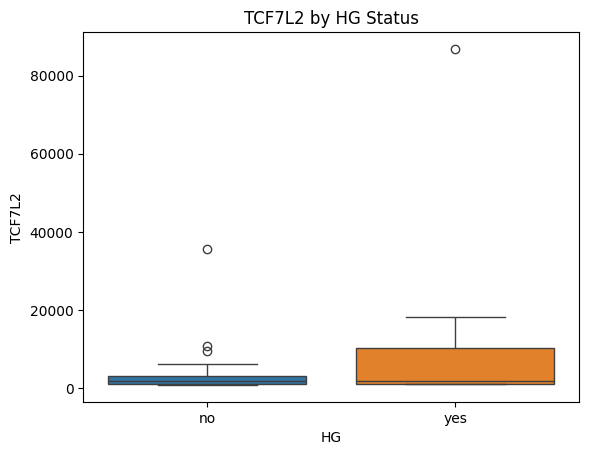

In [28]:
dist_boxplot(madres, 'TCF7L2')

#### Stat Sig - No

In [30]:
perform_statistical_tests(madres, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.00012186175531484438
Shapiro-Wilk test for no (n=32): p-value = 4.528365038346296e-10
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 127.0, p-value = 0.603257655889235


#### Look into TCF7L2 outlier in Madres Data for Patients with HG
* Not removing the outliers for patients without HG.

In [31]:
madres_hg[madres_hg['TCF7L2'] > 15000]

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
2,hg,yes,madres,154_IN05817,NaT,1,86824.003245,17909.352716,110847.711827,11.5700,...,NaN,14.0,179.03,NaN,NaN,High,Unknown,NaN,NaN,NaN
8,hg,yes,madres,234_IL00110,NaT,1,18194.973502,8682.455324,104781.504733,7.8571,...,NaN,13.0,133.02,NaN,NaN,High,Unknown,NaN,NaN,NaN


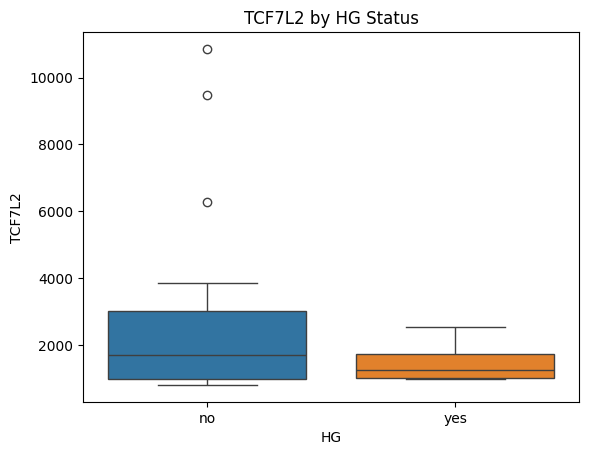

In [32]:
madres_tcf_outlier_removed = madres[madres['TCF7L2'] < 15000]
dist_boxplot(madres_tcf_outlier_removed, 'TCF7L2')

#### Stat Sig - No

In [34]:
perform_statistical_tests(madres_tcf_outlier_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=5): p-value = 0.19535453246415935
Shapiro-Wilk test for no (n=31): p-value = 1.0342060195722727e-06
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=5 vs. n=31): U-statistic = 64.0, p-value = 0.5631737543502249


### Insights
* While there is no statistical significance, these results are consistent with hypothesis that TCF7L2 may serve as a protective feature of HG **when the outliers are removed**. Otherwise, the outliers skew the TCf7L2 distribution and increase the mean.
    * However, n=4 for patients with HG when outliers are removed (madres data only).

### GDF15 by HG Status

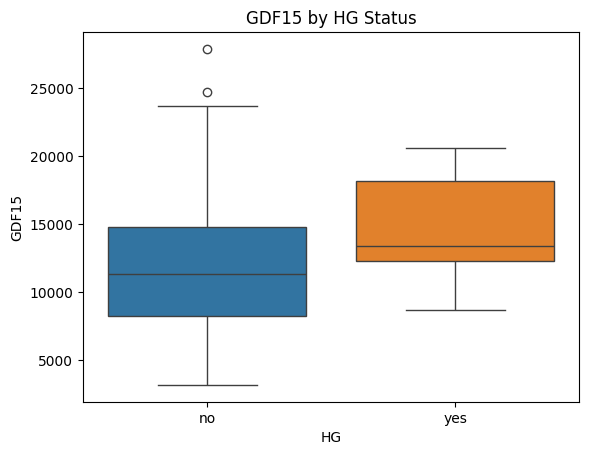

In [35]:
dist_boxplot(madres, 'GDF15')

#### Stat Sig - No

In [36]:
perform_statistical_tests(madres, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.7308156539847404
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325256
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 149.0, p-value = 0.18588204346718282


### IGFBP7 by HG Status

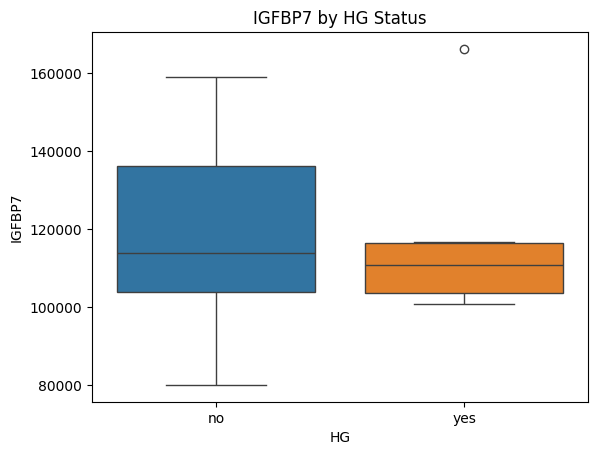

In [37]:
dist_boxplot(madres, 'IGFBP7')

#### Stat Sig - No

In [38]:
perform_statistical_tests(madres, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.004329627008323086
Shapiro-Wilk test for no (n=32): p-value = 0.14611655967724135
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 100.0, p-value = 0.673844019973223


#### Look into IGFBP7 outlier in Madres Data

In [39]:
madres_hg[madres_hg['IGFBP7'] > 140000]

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
10,hg,yes,madres,26_RD09972,NaT,1,996.911824,13093.175085,166242.875982,10.857,...,NaN,13.0,155.0264,NaN,NaN,High,Unknown,NaN,NaN,NaN


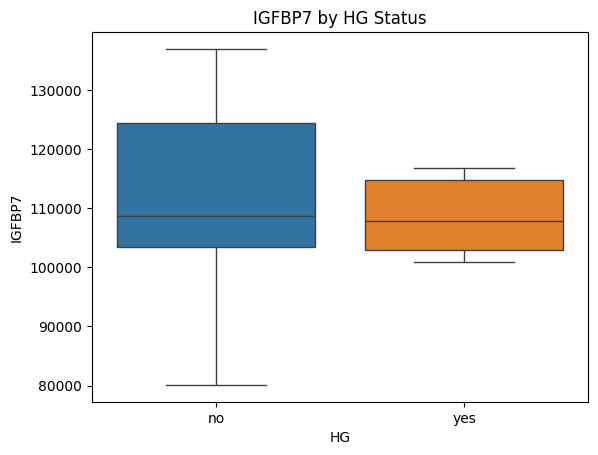

In [40]:
# boxplot with outlier removed
madres_igf_outlier_removed = madres[madres['IGFBP7'] < 140000]
dist_boxplot(madres_igf_outlier_removed, 'IGFBP7')

#### Stat Sig - No

In [46]:
perform_statistical_tests(madres_igf_outlier_removed, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=6): p-value = 0.2896623760428171
Shapiro-Wilk test for no (n=26): p-value = 0.3278865912384915
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=6 vs. n=26): t-statistic = -0.3425735479920608, p-value = 0.7343080090095471
Welch's t-test result (n=6 vs. n=26): t-statistic = -0.5478251374766694, p-value = 0.5901083734906489


##### Remove Outliers

In [47]:
# madres df with both igf and tcf outliers removed
condition1 = madres['IGFBP7'] < 140000 
condition2 = madres['TCF7L2'] < 18000
combined_condition = condition1 & condition2
madres_tcf_igf_outliers_removed = madres[combined_condition]

### Protein Distribution by Race
*  Only for Latina patients since there is only 1 Black patient with HG and 0 White patients with HG.

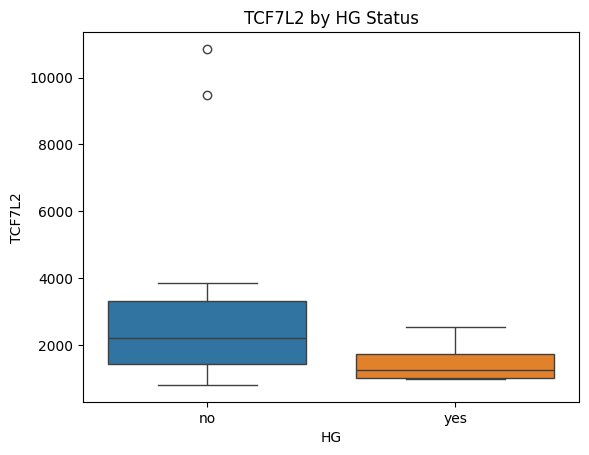

In [51]:
madres_latina = madres[madres['Race'] == 'latina']
latina_condition = madres['Race'] == 'latina'
tcf_condition = madres['TCF7L2'] < 18000 
combined = latina_condition & tcf_condition
madres_latina_tcf_outlier_removed = madres[combined]
dist_boxplot(madres_latina_tcf_outlier_removed, 'TCF7L2')

#### Stat Sig - No

In [52]:
perform_statistical_tests(madres_latina_tcf_outlier_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=5): p-value = 0.19535453246415935
Shapiro-Wilk test for no (n=17): p-value = 0.00015874665959113524
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=5 vs. n=17): U-statistic = 28.0, p-value = 0.28267638793954586


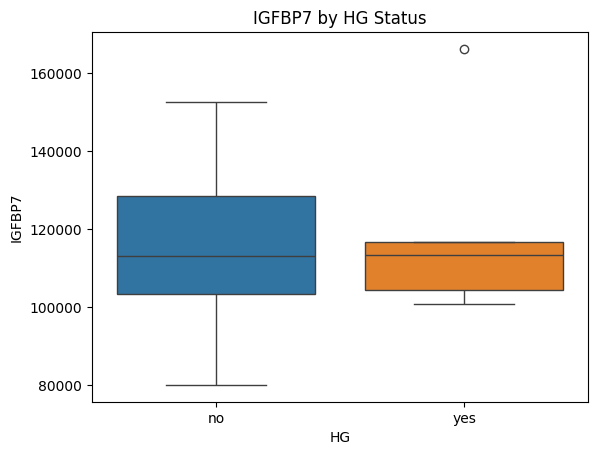

In [53]:
dist_boxplot(madres_latina, 'IGFBP7')

#### Stat Sig - No

In [54]:
perform_statistical_tests(madres_latina, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=6): p-value = 0.016780596062316862
Shapiro-Wilk test for no (n=17): p-value = 0.8124614872451918
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=6 vs. n=17): U-statistic = 50.0, p-value = 0.9720672590138447


## Protein Expression Avg Madres with HG and Madres without HG - Madres Clinic (outliers removed)

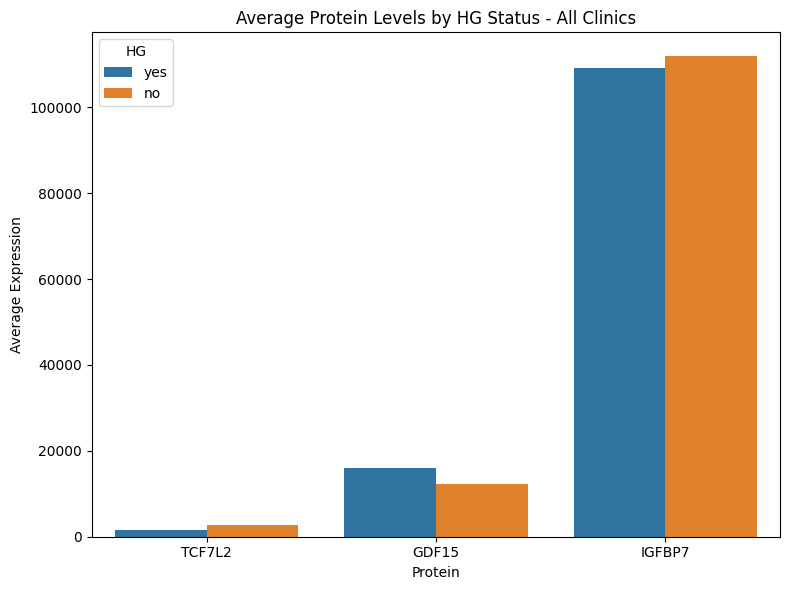

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.6918 (⛔ Not significant) — n_yes = 4, n_no = 25
GDF15: p = 0.1810 (⛔ Not significant) — n_yes = 4, n_no = 25
IGFBP7: p = 0.5908 (⛔ Not significant) — n_yes = 4, n_no = 25


In [55]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
avg_data = []
p_values = {}

for protein in proteins:
    hg_yes = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'yes'][protein].dropna()
    hg_no = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    avg_data.append({'Protein': protein, 'HG': 'yes', 'Average': hg_yes.mean(), 'N': n_yes})
    avg_data.append({'Protein': protein, 'HG': 'no', 'Average': hg_no.mean(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
avg_df = pd.DataFrame(avg_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_df, x='Protein', y='Average', hue='HG')
plt.title('Average Protein Levels by HG Status - All Clinics')
plt.ylabel('Average Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Protein Expression Median Madres with HG and Madres without HG - Madres Clinic (outliers removed)

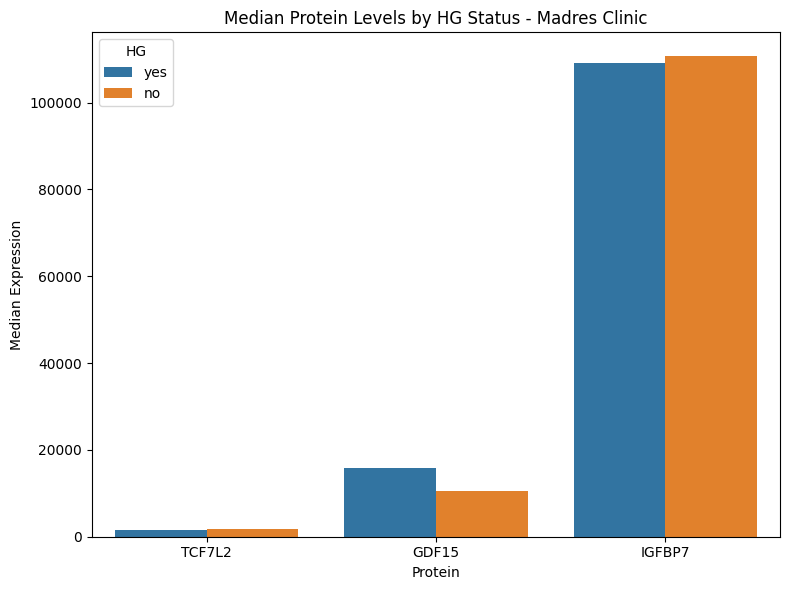

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.6918 (⛔ Not significant) — n_yes = 4, n_no = 25
GDF15: p = 0.1810 (⛔ Not significant) — n_yes = 4, n_no = 25
IGFBP7: p = 0.5908 (⛔ Not significant) — n_yes = 4, n_no = 25


In [56]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
median_data = []
p_values = {}

for protein in proteins:
    hg_yes = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'yes'][protein].dropna()
    hg_no = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    median_data.append({'Protein': protein, 'HG': 'yes', 'Median': hg_yes.median(), 'N': n_yes})
    median_data.append({'Protein': protein, 'HG': 'no', 'Median': hg_no.median(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
median_df = pd.DataFrame(median_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=median_df, x='Protein', y='Median', hue='HG')
plt.title('Median Protein Levels by HG Status - Madres Clinic')
plt.ylabel('Median Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

# All Clinics Data

## Protein Expression Median Madres without HG and all Patients with HG - All Clinics
* Only references first visit to ensure independence

In [57]:
first_visits = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

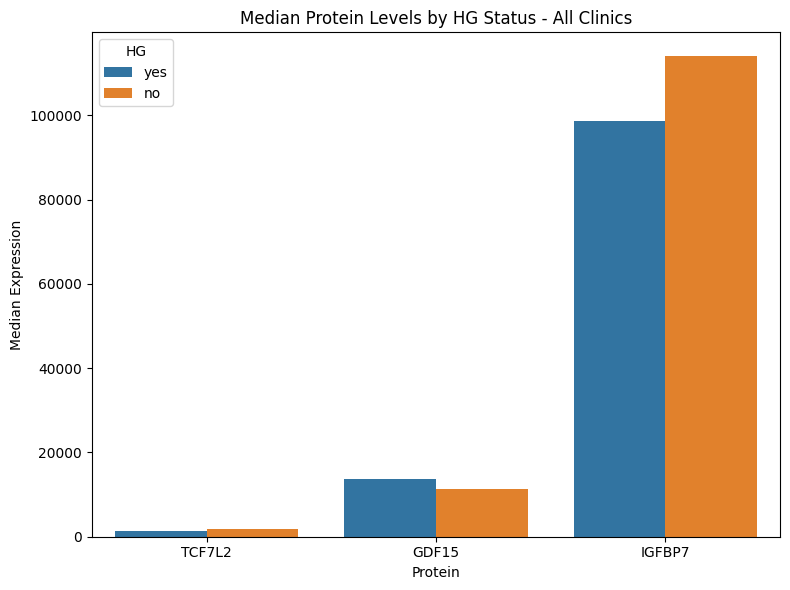

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.3897 (⛔ Not significant) — n_yes = 106, n_no = 32
GDF15: p = 0.0277 (✳️ Significant) — n_yes = 106, n_no = 32
IGFBP7: p = 0.0000 (✳️ Significant) — n_yes = 106, n_no = 32


In [58]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
median_data = []
p_values = {}

for protein in proteins:
    hg_yes = first_visits[first_visits['HG'] == 'yes'][protein].dropna()
    hg_no = first_visits[first_visits['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    median_data.append({'Protein': protein, 'HG': 'yes', 'Median': hg_yes.median(), 'N': n_yes})
    median_data.append({'Protein': protein, 'HG': 'no', 'Median': hg_no.median(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
median_df = pd.DataFrame(median_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=median_df, x='Protein', y='Median', hue='HG')
plt.title('Median Protein Levels by HG Status - All Clinics')
plt.ylabel('Median Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Protein Expression Avg Madres without HG and all Patients with HG - All Clinics
* Only references first visit to ensure independence

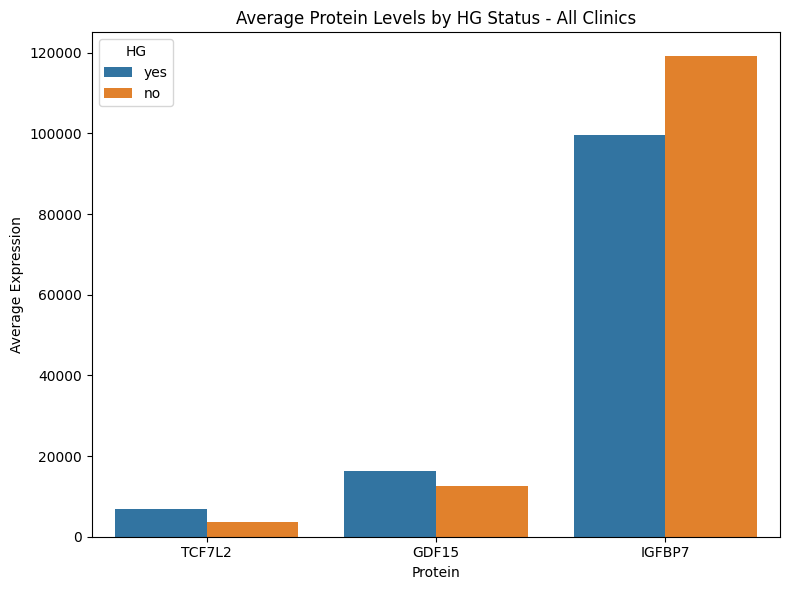

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.3897 (⛔ Not significant) — n_yes = 106, n_no = 32
GDF15: p = 0.0277 (✳️ Significant) — n_yes = 106, n_no = 32
IGFBP7: p = 0.0000 (✳️ Significant) — n_yes = 106, n_no = 32


In [59]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
avg_data = []
p_values = {}

for protein in proteins:
    hg_yes = first_visits[first_visits['HG'] == 'yes'][protein].dropna()
    hg_no = first_visits[first_visits['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    avg_data.append({'Protein': protein, 'HG': 'yes', 'Average': hg_yes.mean(), 'N': n_yes})
    avg_data.append({'Protein': protein, 'HG': 'no', 'Average': hg_no.mean(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
avg_df = pd.DataFrame(avg_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_df, x='Protein', y='Average', hue='HG')
plt.title('Average Protein Levels by HG Status - All Clinics')
plt.ylabel('Average Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Boxplot Distributions - All Clinics
* Only first visits to ensure independence.

In [60]:
first_visits = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

### PUQE by HG Status

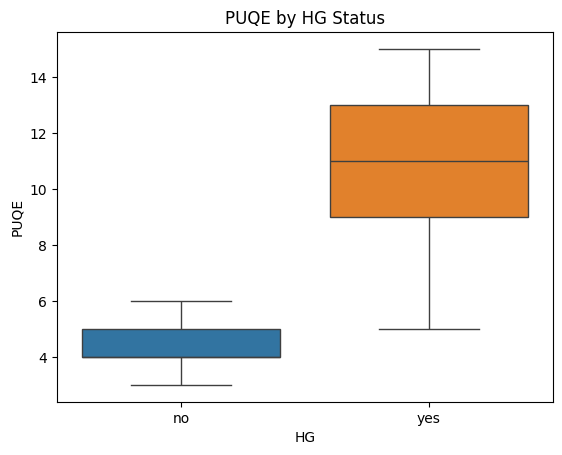

In [61]:
dist_boxplot(first_visits, 'PUQE')

#### Stat Sig - Yes (to be expected)

In [62]:
perform_statistical_tests(first_visits, "HG", "PUQE", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 7.191087344790055e-05
Shapiro-Wilk test for no (n=32): p-value = 0.0014658277589733213
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 3350.0, p-value = 1.3685282086070814e-17


### EGA by HG Status (All Clinics)

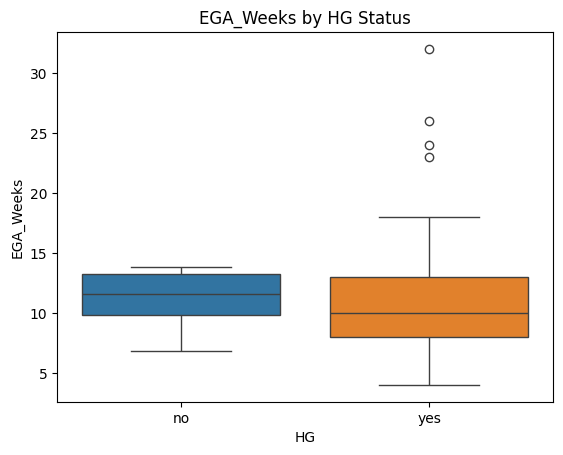

In [63]:
dist_boxplot(first_visits, 'EGA_Weeks')

#### Stat Sig - No

In [64]:
perform_statistical_tests(first_visits, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=101): p-value = 2.1730033369014524e-09
Shapiro-Wilk test for no (n=32): p-value = 0.01805836587254208
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=101 vs. n=32): U-statistic = 1286.0, p-value = 0.08224216680641369


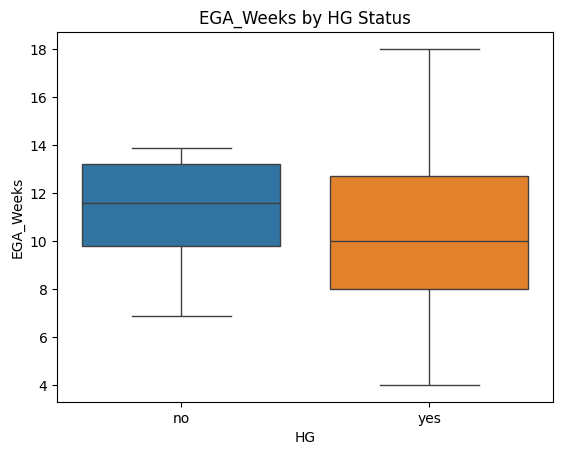

In [67]:
# remove EGA outliers
first_visits_ega_outliers_removed = first_visits[first_visits['EGA_Weeks'] < 20]
dist_boxplot(first_visits_ega_outliers_removed, 'EGA_Weeks')

#### Stat Sig - Yes (when outliers removed)

In [68]:
perform_statistical_tests(first_visits_ega_outliers_removed, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=97): p-value = 0.006488583761728056
Shapiro-Wilk test for no (n=32): p-value = 0.01805836587254208
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=97 vs. n=32): U-statistic = 1158.0, p-value = 0.03151873902522456


### Insights
* When EGA_Weeks outliers are removed, there is a statistically significant difference in the average EGA between groups with and without HG.
    * This indicates that patients with HG, came in earlier, on average, for their first patient.

### Prepregnancy Weight by HG Status (All Clinics)

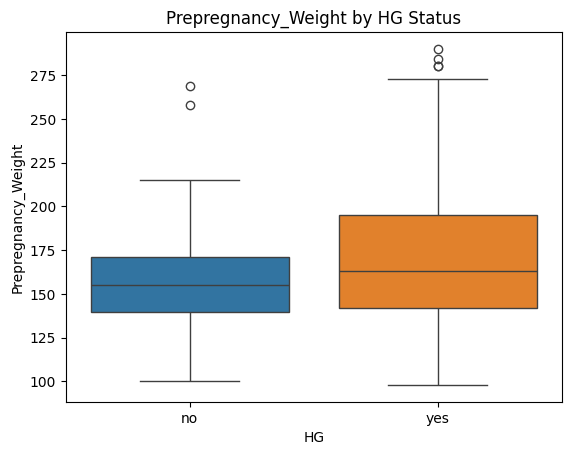

In [69]:
dist_boxplot(first_visits, 'Prepregnancy_Weight')

#### Stat Sig - No

In [141]:
perform_statistical_tests(first_visits, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 8.660665184512012e-05
Shapiro-Wilk test for no (n=32): p-value = 0.002839808874140585
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 1888.0, p-value = 0.29111479221203473


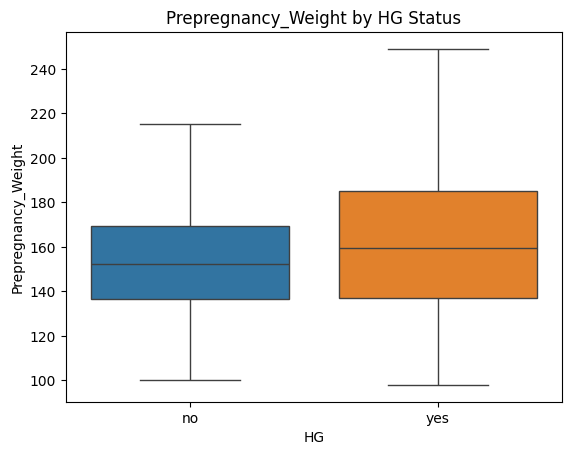

In [72]:
# remove Prepreg weight outliers
first_visits_prepreg_weight_outliers_removed = first_visits[first_visits['Prepregnancy_Weight'] < 250]
dist_boxplot(first_visits_prepreg_weight_outliers_removed, 'Prepregnancy_Weight')

#### Stat Sig - No

In [73]:
perform_statistical_tests(first_visits_prepreg_weight_outliers_removed, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=96): p-value = 0.027522945167997453
Shapiro-Wilk test for no (n=30): p-value = 0.8769001559151586
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=96 vs. n=30): U-statistic = 1604.0, p-value = 0.3489675016930387


### TCF7L2 by HG Status (All Clinics)

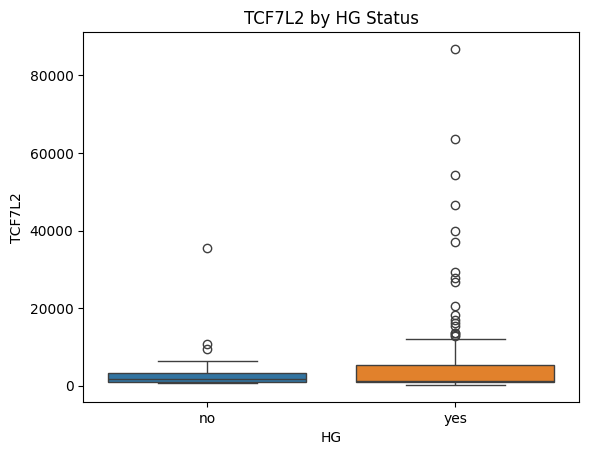

In [142]:
dist_boxplot(first_visits, 'TCF7L2')

##### Stat Sig - No

In [143]:
perform_statistical_tests(first_visits, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 4.5044163374144926e-17
Shapiro-Wilk test for no (n=32): p-value = 4.528365038346296e-10
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 1525.0, p-value = 0.38970036852807977


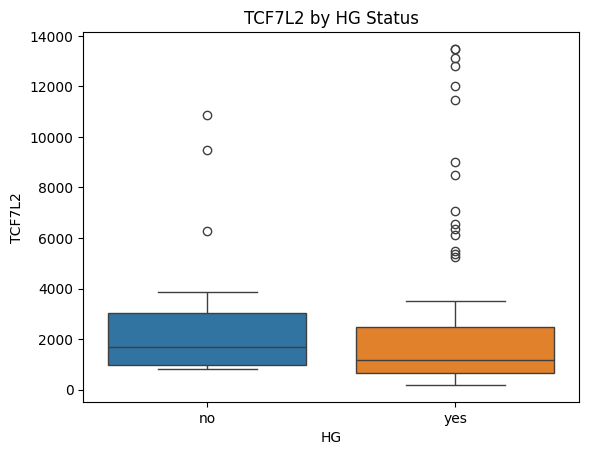

In [159]:
# remove TCF7L2 outliers 
first_visits_tcf_outliers_removed = first_visits[first_visits['TCF7L2'] < 15250]
dist_boxplot(first_visits_tcf_outliers_removed, 'TCF7L2')

##### Stat Sig - Yes (when outliers > 15250 removed)

In [161]:
perform_statistical_tests(first_visits_tcf_outliers_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=92): p-value = 1.390333642360283e-13
Shapiro-Wilk test for no (n=31): p-value = 1.0342060195722727e-06
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=92 vs. n=31): U-statistic = 1085.0, p-value = 0.04731673875484408


### Insights
* These results are consistent with hypothesis that TCF7L2 may serve as a protective feature of HG **when the outliers are removed**. Otherwise, the outliers skew the TCf7L2 distribution and increase the mean.
    * n=92 for patients with HG and n=31 when outliers are removed (all clinic data).

### GDF15 by HG Status (All Clinics)

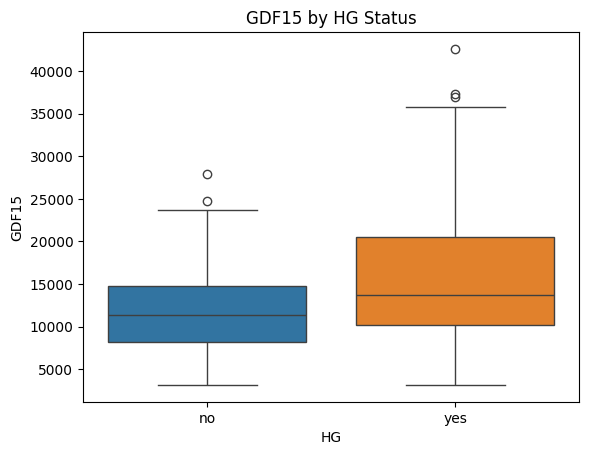

In [74]:
dist_boxplot(first_visits, 'GDF15')

##### Stat Sig - Yes (consistent with previous research)

In [75]:
perform_statistical_tests(first_visits, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 2.3359104560914387e-06
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325256
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 2133.0, p-value = 0.027657345895839854


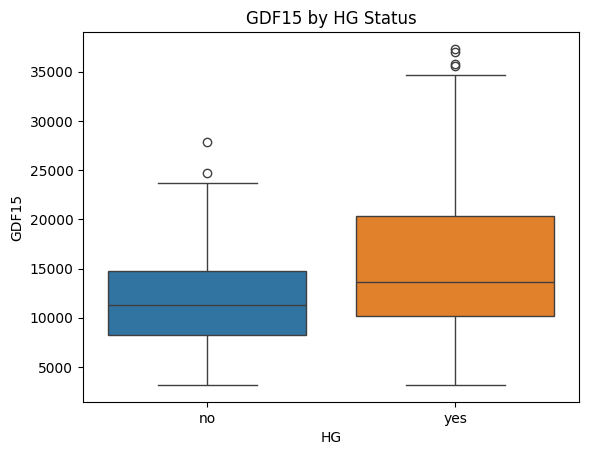

In [80]:
# remove GDF15 outliers 
first_visits_gdf_outliers_removed = first_visits[first_visits['GDF15'] < 40000]
dist_boxplot(first_visits_gdf_outliers_removed, 'GDF15')

##### Stat Sig - Yes (consistent with previous research)

In [81]:
perform_statistical_tests(first_visits_gdf_outliers_removed, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 4.696937673723056e-06
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325256
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 2101.0, p-value = 0.03242104875792999


### Insights
* These results are consistent with previous research that indicates higher levels of GDF15 for patients with HG. 
    * Even when outliers are removed.

### IGFBP7 by HG Status (All Clinics)

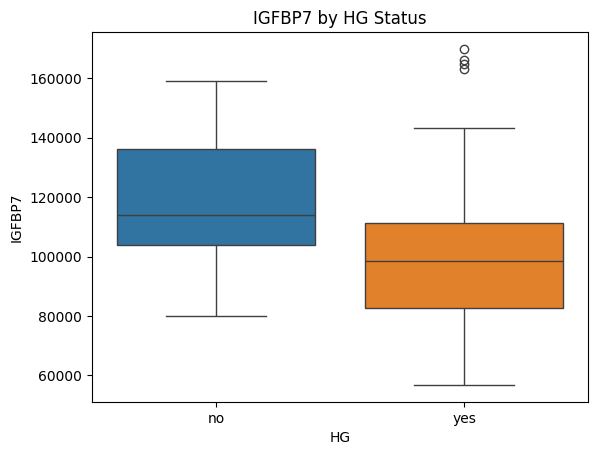

In [82]:
dist_boxplot(first_visits, 'IGFBP7')

#### Stat Sig - Yes

In [83]:
perform_statistical_tests(first_visits, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 2.3359104560914387e-06
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325256
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 2133.0, p-value = 0.027657345895839854


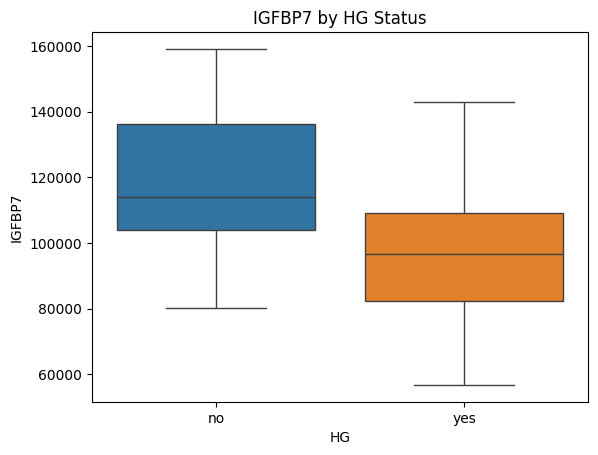

In [84]:
# remove IGFBP7 outliers 
first_visits_igf_outliers_removed = first_visits[first_visits['IGFBP7'] < 160000]
dist_boxplot(first_visits_igf_outliers_removed, 'IGFBP7')

#### Stat Sig - Yes

In [85]:
perform_statistical_tests(first_visits_igf_outliers_removed, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=102): p-value = 0.6442790830425523
Shapiro-Wilk test for no (n=32): p-value = 0.14611655967724135
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=102 vs. n=32): t-statistic = -5.571292524024453, p-value = 1.3638438120220002e-07
Welch's t-test result (n=102 vs. n=32): t-statistic = -5.048516552724184, p-value = 7.77711018045512e-06


### Insights
* These results are inconsistent with previous research that indicates a higher level of IGFBP7 present in patients with HG.

## Race Boxplots

### Latina